## Overview

KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.

In this project, we will build an algorithm that predicts whether a user will churn after their subscription expires. Here, we will determine that churn has occured if the customer has not renewed their subscription 30 days after it has expired or has been cancelled. Currently, the company uses survival analysis techniques to determine the residual membership life time for each subscriber. By adopting different methods, KKBOX anticipates they’ll discover new insights to why users leave so they can be proactive in keeping users dancing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import time


from sklearn.model_selection import cross_val_score

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#dimension reduction
from sklearn.decomposition import PCA

# Feature Scaling for modelling purpose by using both min-max-scaling
from sklearn.preprocessing import MinMaxScaler

In [2]:
s=time.time()
train = pd.read_csv('input/train_v2.csv') #contains the true churn values
print("Finished importing train in "+str(round(time.time()-s,2)))
sample_submission = pd.read_csv('input/sample_submission_v2.csv') #only relevent for kaggle submission purposes
print("Finished importing sample_submission in "+str(round(time.time()-s,2)))
transactions = pd.read_csv('input/transactions_v2.csv') #contains transaction data
print("Finished importing transactions in "+str(round(time.time()-s,2)))
user_logs = pd.read_csv('input/user_logs_v2.csv') #contains intra day data related to usage
print("Finished importing user_logs in "+str(round(time.time()-s,2)))
members = pd.read_csv('input/members_v3.csv')
print("Finished importing members in "+str(round(time.time()-s,2)))

Finished importing train in 0.75
Finished importing sample_submission in 1.47
Finished importing transactions in 2.93
Finished importing user_logs in 25.44
Finished importing members in 31.44


In [17]:
sample_submission.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [10]:
train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [11]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [5]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [7]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [12]:
# check the number of duplicate accounts in each table
print(train.duplicated('msno').sum())
print(sample_submission.duplicated('msno').sum())
print(transactions.duplicated('msno').sum())
print(user_logs.duplicated('msno').sum())
print(members.duplicated('msno').sum())

0
0
233959
17292468
0


In [16]:
#check number of columns and rows for each df
print(train.shape)
print(sample_submission.shape)
print(transactions.shape)
print(user_logs.shape)
print(members.shape)

(970960, 2)
(907471, 2)
(1431009, 9)
(18396362, 9)
(6769473, 6)


Transactions and user_logs contain duplicate msno values because they provide granular data for each user per day. We will need to group the data by the msno column (user id) in order to merge it with the rest of the data.


## Explore feature correlation to target variable (is_churn)

Let's begin by briefly taking a look at how each of our features are correlated with the target variable. A low correlation does not necessarily mean that we should remove the feauture becuase it is not an accurate metric for classification models which only predict binary values. 

In [54]:
#explore members
members.merge(train, on='msno',how='inner').corr()

,city,bd,registered_via,registration_init_time,is_churn
city,1.000000,0.513068,0.018996,-0.361908,0.081424
bd,0.513068,1.000000,0.067176,-0.393429,0.065719
registered_via,0.018996,0.067176,1.000000,-0.382191,-0.080642
registration_init_time,-0.361908,-0.393429,-0.382191,1.000000,-0.000021
is_churn,0.081424,0.065719,-0.080642,-0.000021,1.000000


Since transactions and user_logs contain duplicate user id rows, we need to first group by the msno column (user ids) to synthesize the data into useful results. 

In [53]:
# returns the max value of numerical variables and membership_expire_date
# returns the min value of transaction date
# returns the mode of ordinal variable and dummy variables, if multiple values share the same frequency, keep the first one
transactions_v2 = transactions.groupby('msno', as_index = False).agg({'payment_method_id': lambda x:x.value_counts().index[0], 'payment_plan_days': 'max', 'plan_list_price': 'max',
                                       'actual_amount_paid': 'max', 'is_auto_renew': lambda x:x.value_counts().index[0], 'transaction_date': 'min', 'membership_expire_date': 'max',
                                       'is_cancel': lambda x:x.value_counts().index[0]})


In [151]:
transactions_v2

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,20161023,20180206,0
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170315,20170415,0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,20170228,20170519,0
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20170326,20170426,0
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,20170315,20170415,0
...,...,...,...,...,...,...,...,...,...
1197045,zzy0oyiTnRTo5Mbg23oKbBkf9eoaS7+eU4V+d14bzfY=,22,195,894,894,0,20161110,20170527,0
1197046,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,20170228,20170401,0
1197047,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,29,30,180,180,0,20170311,20170410,0
1197048,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,20170228,20170524,0


In [55]:
transactions_v2.merge(train, on='msno',how='inner').corr()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn
payment_method_id,1.000000,-0.264237,-0.326858,-0.325411,0.326347,-0.043490,-0.127438,-0.020496,-0.203389
payment_plan_days,-0.264237,1.000000,0.965855,0.965449,-0.361611,-0.025068,0.656398,0.005977,0.455526
plan_list_price,-0.326858,0.965855,1.000000,0.999404,-0.394782,-0.034520,0.647513,0.017064,0.447071
actual_amount_paid,-0.325411,0.965449,0.999404,1.000000,-0.394979,-0.034559,0.647361,0.016842,0.444360
is_auto_renew,0.326347,-0.361611,-0.394782,-0.394979,1.000000,-0.009964,-0.184528,0.052175,-0.308546
transaction_date,-0.043490,-0.025068,-0.034520,-0.034559,-0.009964,1.000000,-0.415458,0.014457,-0.155364
membership_expire_date,-0.127438,0.656398,0.647513,0.647361,-0.184528,-0.415458,1.000000,-0.009109,0.286451
is_cancel,-0.020496,0.005977,0.017064,0.016842,0.052175,0.014457,-0.009109,1.000000,0.437393
is_churn,-0.203389,0.455526,0.447071,0.444360,-0.308546,-0.155364,0.286451,0.437393,1.000000


The user_logs dataframe contains interesting information related to each users intra day usage. I've also created some new features, such as:
 - counts_30: number of days the user used the service this month
 - counts_60: number of days the user used the service the month prior
 - num_unq_30: numbe of unique songs the user listened to this month
 - num_unq_30: numbe of unique songs the user listened to in the month prior
 - total_secs_30: total seconds of music listened to this month
 - total_secs_60: total seconds of music listened to in the month prior
 - days_since_last: how long it's been since the user last used the service (in days)
 

In [153]:
# Explore user_logs

#convert dates to datetime obj
user_logs['date'] = pd.to_datetime(user_logs['date'], format = '%Y%m%d')

#print latest date
user_logs['date'].max()

Timestamp('2017-03-31 00:00:00')

In [154]:
# returns the max value of date and number of unique songs
# returns the sum of other variables
user_logs_v2 = user_logs.groupby('msno', as_index = False).agg({'date': 'max', 'num_25': 'sum', 'num_50': 'sum', 'num_75': 'sum',
                                 'num_985': 'sum', 'num_100': 'sum', 'num_unq': 'max', 'total_secs': 'sum'})

#change date to max_date
user_logs_v2.columns = ['msno', 'max_date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs']


In [155]:
#shift the dates back 30, 60 and 90 days
temp = user_logs.copy()
temp['max_date'] = user_logs_v2['max_date']
temp['last_30_days'] = temp['max_date'] - pd.Timedelta(days=30)
temp['last_60_days'] = temp['max_date'] - pd.Timedelta(days=60)
temp['last_90_days'] = temp['max_date'] - pd.Timedelta(days=90)

#group by msno to get total counts of days, total unique songs, and total seconds for 30/60/90 days
temp1 = temp[temp['date']>=temp['last_30_days']]
temp1_groupby = temp1.groupby(['msno']).agg({'msno': 'count', 'num_unq': 'sum', 'total_secs':'sum'})
temp1_groupby.columns = ['counts_30', 'num_unq_30', 'total_secs_30']
temp1_groupby.reset_index(inplace=True)

temp2 = temp[temp['date']>=temp['last_60_days']]
temp2_groupby = temp2.groupby(['msno']).agg({'msno': 'count', 'num_unq': 'sum', 'total_secs':'sum'})
temp2_groupby.columns = ['counts_60', 'num_unq_60', 'total_secs_60']
temp2_groupby.reset_index(inplace=True)


temp3 = temp[temp['date']>=temp['last_90_days']]
temp3_groupby = temp3.groupby(['msno']).agg({'msno': 'count', 'num_unq': 'sum', 'total_secs':'sum'})
temp3_groupby.columns = ['counts_90', 'num_unq_90', 'total_secs_90']
temp3_groupby.reset_index(inplace=True)


#merge back to user_logs_v2
user_logs_v2 = user_logs_v2.merge(temp1_groupby, on='msno', how='left')
user_logs_v2 = user_logs_v2.merge(temp2_groupby, on='msno', how='left')
user_logs_v2 = user_logs_v2.merge(temp3_groupby, on='msno', how='left')


In [252]:
temp1_groupby.head()

,msno,counts_30,num_unq_30,total_secs_30
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3,25,4245.614
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,1,5,924.747
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1,7,1395.247
3,++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY=,2,58,10594.449
4,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,2,9,1650.342


In [157]:
#how long has it been since the user last used the service?
user_logs_v2['today'] = pd.to_datetime('2017-03-31 00:00:00')
#user_logs_v2['days_since_last'] = pd.Timedelta(user_logs_v2['today'] - user_logs_v2['max_date']).seconds
user_logs_v2['days_since_last'] = (user_logs_v2['today'] - user_logs_v2['max_date']).dt.days


In [158]:
# to make these columns more useful, convert them to percentages
# calculate the percentage of number of songs played within certain period
user_logs_v2['percent_25'] = user_logs_v2['num_25']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_50'] = user_logs_v2['num_50']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_100'] = (user_logs_v2['num_985']+user_logs_v2['num_100'])/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])

# drop useless variables
user_logs_v3 = user_logs_v2.drop(columns = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [251]:
user_logs_v3.head()

,msno,max_date,num_unq,total_secs,counts_30,num_unq_30,total_secs_30,counts_60,num_unq_60,total_secs_60,counts_90,num_unq_90,total_secs_90,today,days_since_last,percent_25,percent_50,percent_100
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2017-03-31,139,117907.425,3.0,25.0,4245.614,3.0,25.0,4245.614,3.0,25.0,4245.614,2017-03-31,0,0.147260,0.018836,0.816781
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-03-31,59,192527.892,1.0,5.0,924.747,1.0,5.0,924.747,1.0,5.0,924.747,2017-03-31,0,0.175390,0.082645,0.673095
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2017-03-31,43,115411.260,1.0,7.0,1395.247,1.0,7.0,1395.247,1.0,7.0,1395.247,2017-03-31,0,0.075838,0.021164,0.876543
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2017-03-30,124,149896.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31,1,0.213402,0.168041,0.515464
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,2017-03-31,34,116433.247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-31,0,0.153959,0.035191,0.753666


In [250]:
#explore correlation with target variable
# user_logs_v3.merge(train, on='msno',how='inner').corr()

## Building the training data

Create the training data by combining all the data together into one big df. Next train the machine learning model using a variety of different classifer and ensemble models. 

I've also created one additional feauture:
- days_since_reg : total number of days the user has been a subscriber

In [160]:
# merge between different tables for modelling purpose
dataset_train = train.merge(members, on = 'msno', how = 'left').merge(transactions_v2, on = 'msno', how = 'left').merge(user_logs_v3, on = 'msno', how = 'left')



In [162]:
#create one more features


#convert to datetime objs
dataset_train['transaction_date'] = pd.to_datetime(dataset_train['transaction_date'], format = '%Y%m%d')
dataset_train['membership_expire_date'] = pd.to_datetime(dataset_train['membership_expire_date'], format = '%Y%m%d')

#length of usage in days (transaction_date is the registration date since groupby looked for the min value)
dataset_train['days_since_reg'] = (dataset_train['max_date'] - dataset_train['transaction_date']).dt.days


In [164]:
dataset_train.corr()

,is_churn,city,bd,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,...,num_unq_60,total_secs_60,counts_90,num_unq_90,total_secs_90,days_since_last,percent_25,percent_50,percent_100,days_since_reg
is_churn,1.000000,0.081424,0.065719,-0.080642,-0.000021,-0.203389,0.455526,0.447071,0.444360,-0.308546,...,0.003036,-0.001849,-0.011904,0.003036,-0.001849,0.240268,-0.000909,0.013699,-0.006166,0.073581
city,0.081424,1.000000,0.513068,0.018996,-0.361908,-0.320780,0.075164,0.151435,0.150646,-0.108601,...,0.066044,0.064649,0.030355,0.066044,0.064649,-0.056009,-0.063617,-0.020076,0.060653,0.005803
bd,0.065719,0.513068,1.000000,0.067176,-0.393429,-0.294024,0.065947,0.128419,0.127954,-0.067386,...,0.052848,0.059485,0.018242,0.052848,0.059485,-0.036742,-0.066314,-0.029842,0.066638,0.001374
registered_via,-0.080642,0.018996,0.067176,1.000000,-0.382191,-0.003564,-0.014294,-0.031686,-0.031468,0.187697,...,-0.002927,0.007146,-0.004434,-0.002927,0.007146,-0.013843,-0.021183,-0.010876,0.020731,-0.009764
registration_init_time,-0.000021,-0.361908,-0.393429,-0.382191,1.000000,0.248417,-0.020183,-0.084564,-0.084621,-0.053937,...,-0.028599,-0.037696,-0.010918,-0.028599,-0.037696,0.048580,0.075851,0.037985,-0.076660,-0.024905
payment_method_id,-0.203389,-0.320780,-0.294024,-0.003564,0.248417,1.000000,-0.264237,-0.326858,-0.325411,0.326347,...,-0.056570,-0.055712,-0.026070,-0.056570,-0.055712,0.069244,0.024106,0.003930,-0.022099,0.054430
payment_plan_days,0.455526,0.075164,0.065947,-0.014294,-0.020183,-0.264237,1.000000,0.965855,0.965449,-0.361611,...,0.023489,0.018953,0.014151,0.023489,0.018953,-0.040747,-0.010593,-0.002477,0.009803,0.026105
plan_list_price,0.447071,0.151435,0.128419,-0.031686,-0.084564,-0.326858,0.965855,1.000000,0.999404,-0.394782,...,0.034812,0.029995,0.021054,0.034812,0.029995,-0.060400,-0.021573,-0.007462,0.020878,0.035957
actual_amount_paid,0.444360,0.150646,0.127954,-0.031468,-0.084621,-0.325411,0.965449,0.999404,1.000000,-0.394979,...,0.034717,0.029870,0.021083,0.034717,0.029870,-0.060373,-0.021457,-0.007413,0.020762,0.036105
is_auto_renew,-0.308546,-0.108601,-0.067386,0.187697,-0.053937,0.326347,-0.361611,-0.394782,-0.394979,1.000000,...,-0.052298,-0.035371,-0.038943,-0.052298,-0.035371,0.107464,-0.023622,-0.024604,0.028399,0.008856


Next we will remove rows which are not useful in predicting churn, such as msno, bd, transaction_date, etc. 
The data set contains lot of missing values, so we will need to figure out a method to fill in the missing values with mean/mode.

In [165]:
# remove useless rows AND
#remove gender and age since missing value or incorrect value is over 50%
dataset_train_v2 = dataset_train.drop(columns = ['msno', 'gender', 'bd', 'registration_init_time', 'transaction_date', 'membership_expire_date', 'max_date', 'today'])
dataset_train_v2.dtypes

# check the number of missing values in each column
dataset_train_v2.isna().sum()

is_churn                   0
city                  109993
registered_via        109993
payment_method_id      37382
payment_plan_days      37382
plan_list_price        37382
actual_amount_paid     37382
is_auto_renew          37382
is_cancel              37382
num_unq               216409
total_secs            216409
counts_30             514347
num_unq_30            514347
total_secs_30         514347
counts_60             514347
num_unq_60            514347
total_secs_60         514347
counts_90             514347
num_unq_90            514347
total_secs_90         514347
days_since_last       216409
percent_25            216409
percent_50            216409
percent_100           216409
days_since_reg        245224
dtype: int64

In [168]:
# Handle missing value of part of numeric columns by using mode
def replacemode(i):
    dataset_train_v2[i] = dataset_train_v2[i].fillna(dataset_train_v2[i].value_counts().index[0])
    return 

replacemode('city')
replacemode('registered_via')
replacemode('payment_method_id')
replacemode('payment_plan_days')
replacemode('is_auto_renew')
replacemode('is_cancel')

# Handle missing value of part of numeric columns by using mean
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

def replacemean(i):
    dataset_train_v2[i] = mean_imputer.fit_transform(dataset_train_v2[[i]])
    return 

replacemean('plan_list_price')
replacemean('actual_amount_paid')
replacemean('num_unq')
replacemean('total_secs')
replacemean('percent_25')
replacemean('percent_50')
replacemean('percent_100')
replacemean('days_since_reg')
replacemean('days_since_last')
replacemean('counts_30')
replacemean('counts_60')
replacemean('counts_90')
replacemean('num_unq_30')
replacemean('num_unq_60')
replacemean('num_unq_90')
replacemean('total_secs_30')
replacemean('total_secs_60')
replacemean('total_secs_90')



# Handle outliers by using capping
def replaceoutlier(i):
    mean, std = np.mean(dataset_train_v2[i]), np.std(dataset_train_v2[i])
    cut_off = std*3
    lower, upper = mean - cut_off, mean + cut_off
    dataset_train_v2[i][dataset_train_v2[i] < lower] = lower
    dataset_train_v2[i][dataset_train_v2[i] > upper] = upper
    return

replaceoutlier('plan_list_price')
replaceoutlier('actual_amount_paid')
replaceoutlier('num_unq')
replaceoutlier('total_secs')
replaceoutlier('percent_25')
replaceoutlier('percent_50')
replaceoutlier('percent_100')
replaceoutlier('days_since_reg')
replaceoutlier('days_since_last')
replaceoutlier('counts_30')
replaceoutlier('counts_60')
replaceoutlier('counts_90')
replaceoutlier('num_unq_30')
replaceoutlier('num_unq_60')
replaceoutlier('num_unq_90')
replaceoutlier('total_secs_30')
replaceoutlier('total_secs_60')
replaceoutlier('total_secs_90')


<ipython-input-168-c71421aba1d2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train_v2[i][dataset_train_v2[i] < lower] = lower
<ipython-input-168-c71421aba1d2>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train_v2[i][dataset_train_v2[i] > upper] = upper
<ipython-input-168-c71421aba1d2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train_v2[i][dataset_train_v2[i] < lower] = lower
<ipython-input-168-

In [169]:
dataset_train_v2

,is_churn,city,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_unq,...,num_unq_60,total_secs_60,counts_90,num_unq_90,total_secs_90,days_since_last,percent_25,percent_50,percent_100,days_since_reg
0,1,5.0,3.0,41.0,30.0,145.852706,145.683477,1.0,0.0,158.000000,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,2.000000,0.338182,0.041818,0.596364,18.675720
1,1,13.0,3.0,36.0,30.0,180.000000,180.000000,0.0,0.0,9.000000,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,11.000000,0.000000,0.125000,0.812500,9.000000
2,1,13.0,3.0,15.0,90.0,300.000000,300.000000,0.0,0.0,82.000000,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,0.000000,0.430631,0.102703,0.409009,20.000000
3,1,1.0,7.0,41.0,30.0,149.000000,149.000000,1.0,0.0,65.123435,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,2.705707,0.185996,0.048196,0.736224,18.675720
4,1,13.0,7.0,41.0,30.0,99.000000,99.000000,1.0,0.0,62.000000,...,97.000000,28213.339000,2.000000,97.000000,28213.339000,0.000000,0.009128,0.007099,0.979716,148.313915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970955,0,13.0,7.0,40.0,30.0,149.000000,149.000000,1.0,0.0,70.000000,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,0.000000,0.124352,0.018135,0.847150,27.000000
970956,0,1.0,7.0,41.0,30.0,99.000000,99.000000,1.0,0.0,26.000000,...,26.000000,899.813000,1.000000,26.000000,899.813000,0.000000,0.488636,0.090909,0.329545,21.000000
970957,0,1.0,7.0,41.0,30.0,99.000000,99.000000,1.0,0.0,65.123435,...,50.803735,13879.304627,1.778648,50.803735,13879.304627,2.705707,0.185996,0.048196,0.736224,18.675720
970958,0,5.0,9.0,39.0,30.0,149.000000,149.000000,1.0,0.0,35.000000,...,27.000000,4931.612000,1.000000,27.000000,4931.612000,1.000000,0.083544,0.025316,0.875949,30.000000


In an effort to make the training time faster, I will be using feature scaling and dimension reduction to vectorize the data. 

In [170]:
# Feature Scaling for modelling purpose by using both min-max-scaling
from sklearn.preprocessing import MinMaxScaler
X = dataset_train_v2.drop(columns = ['is_churn'])
Y = dataset_train_v2['is_churn']
nm_X = pd.DataFrame(MinMaxScaler().fit_transform(X))
nm_X.columns = X.columns.values
nm_X.index = X.index.values


In [171]:
#pca reduces dimensionality, and only keeps most important vector
#cons: lose data and accuracy

# Dimension Reduction
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(nm_X)
np.cumsum(pca.explained_variance_ratio_)
mpca=PCA(n_components=10)
nm_X_v2 = mpca.fit_transform(nm_X)

# Split into train and test Set
from sklearn.model_selection import train_test_split
nm_X_train, nm_X_test, nm_Y_train, nm_Y_test = train_test_split(nm_X_v2, Y, test_size = 0.3, random_state = 0)

In [174]:
# Fit training set into different algorithms

#to make things simple, only using logistic regression and xgb classifier

nm_models = []
# nm_models.append(('KNN', KNeighborsClassifier()))
nm_models.append(('LR', LogisticRegression()))
# nm_models.append(('LDA', LinearDiscriminantAnalysis()))
# nm_models.append(('QDA', QuadraticDiscriminantAnalysis()))
# nm_models.append(('CART', DecisionTreeClassifier()))
# nm_models.append(('NB', GaussianNB()))
# # nm_models.append(('Linear SVM', SVC(kernel = 'linear')))
# # nm_models.append(('Kernel SVM', SVC(kernel = 'rbf')))

ensembles = []
# ensembles.append(('BC', BaggingClassifier(base_estimator=LogisticRegression())))
# ensembles.append(('AB', AdaBoostClassifier(base_estimator=LogisticRegression())))
# ensembles.append(('GBM', GradientBoostingClassifier()))
# ensembles.append(('RF', RandomForestClassifier()))
# ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('XGB', XGBClassifier()))


#nm_models
from sklearn.model_selection import cross_val_score
results = []
names = []
for name, model in nm_models:
	nm_cv_results = cross_val_score(model, nm_X_train, nm_Y_train, cv=10, scoring='neg_log_loss', n_jobs = -1)
	results.append(nm_cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, nm_cv_results.mean(), nm_cv_results.std())
	print(msg)
    
#ensembles   
results2 = []
names2 = []
for name2, model2 in ensembles:
	en_cv_results = cross_val_score(model2, nm_X_train, nm_Y_train, cv=10, scoring='neg_log_loss', n_jobs = -1)
	results2.append(en_cv_results)
	names2.append(name2)
	msg2 = "%s: %f (%f)" % (name2, en_cv_results.mean(), en_cv_results.std())
	print(msg2)

LR: -0.214069 (0.001141)
XGB: -0.148262 (0.001632)


[20:49:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


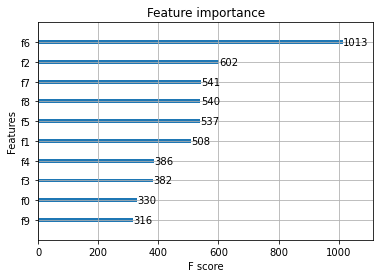

In [180]:
#evaluate feature importance

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model to training data
model = XGBClassifier()
model.fit(nm_X_train, nm_Y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

According to the feature importance chart, "is_auto_renew" is the most important feature in determing wether a customer will churn, followed by the "payment_method_id" and "is_cancel". 
The top 10 are:
 - is_auto_renew
 - payment_method_id
 - is_cancel
 - num_unq
 - actual_amount_paid
 - registered_via
 - plan_list_price
 - payment_plan_days
 - city
 - total_secs


In [248]:
# Apply Grid Search on XGBoost since it returns the best result on Cross Validation among all models
#find the optimal parameters for the model
from sklearn.model_selection import GridSearchCV
parameters = {"learning_rate": [0.1],
              "min_child_weight": [1],
              "max_depth": [9],
              "gamma": [0.1],
              "subsample": [0.8],
              "colsample_bytree": [0.8],
              "objective": ['binary:logistic']}
grid_search_XGB = GridSearchCV(estimator = XGBClassifier(), param_grid = parameters, scoring = "neg_log_loss", cv = 10, n_jobs = -1)
grid_result_XGB = grid_search_XGB.fit(nm_X_train, nm_Y_train)
print("Best: %f using %s" % (grid_result_XGB.best_score_, grid_result_XGB.best_params_)) 

# Evaluate tuned XGBoost model result on test dataset because it provides the best result
from sklearn.metrics import log_loss
nm_Y_predict = grid_result_XGB.predict_proba(nm_X_test)
logloss = log_loss(nm_Y_test, nm_Y_predict)  
print("Log Loss Score: %s" % (logloss))

/Users/nia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.146191 using {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'objective': 'binary:logistic', 'subsample': 0.8}
Log Loss Score: 0.14651804739682245


In [249]:
#save model so you don't have to retrain
import joblib
joblib.dump(grid_result_XGB.best_estimator_, 'trained-models/xgboost_model_v2.pkl')

['trained-models/xgboost_model_v2.pkl']

In [197]:
#Do predictions
final=nm_X.copy()
final["is_churn"]=model.predict(nm_X_v2)

In [234]:
#change column name to "pred_churn" since it's our predicted results
final.columns = ['city', 'registered_via', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'is_cancel',
       'num_unq', 'total_secs', 'counts_30', 'num_unq_30', 'total_secs_30',
       'counts_60', 'num_unq_60', 'total_secs_60', 'counts_90', 'num_unq_90',
       'total_secs_90', 'days_since_last', 'percent_25', 'percent_50',
       'percent_100', 'days_since_reg', 'pred_churn']

In [236]:
#let's add the "is_churn" column (which contains the true churn values) back to the dataframe 
final['is_churn'] = dataset_train['is_churn']

In [242]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_true = final['is_churn']
y_pred = final['pred_churn']
confusion_matrix(y_true, y_pred)



array([[877477,   6153],
       [ 36325,  51005]])

In [245]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_true,y_pred).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

print('\n')

# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(y_true, y_pred)
print('Classification report : \n',matrix)

Outcome values : 
 877477 6153 36325 51005


Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    883630
           1       0.89      0.58      0.71     87330

    accuracy                           0.96    970960
   macro avg       0.93      0.79      0.84    970960
weighted avg       0.95      0.96      0.95    970960



In [247]:
#accuracy
acc = (tp + tn)/(tp + tn + fp + fn)
acc

0.9562515448628162

So far, we see that model has a high accuracy score of 95% and a low log loss value. The model performed poorly in recall, specifically for predicting churned customers (is_churn = 1). The purpose of this project is to retarget customers that the model is predicting will churn, and try to keep them as customers before they cancel their subscription. Targeting customers who are incorrectly predicted to churn (i.e false positives) are okay; however, missing customers who are incorrectly predicted not to churn (false negatives) would be much worse. We see that the model has a much lower recall when predicting customers who will churn to customers who will not. The model was only able to predict 58% of the actual churned cases, meaning that a lot of customers who will churn will be missed. 

To improve the model further, we can try to remove non-important features and compare our scores. From there, we can also do more feature engineering and comapare once more. 


In [ ]:
## submitting to kaggle
# final_2=pd.concat([dataset_train[['msno']],final],axis=1)
# final_2 = final_2.merge(sample_submission['msno'], on='msno', how='right')
# final_3 = final_2[['msno', 'is_churn']]
# final_3['is_churn'] = final_3['is_churn'].fillna(0)
# final_3['is_churn'] = final_3['is_churn'].astype(int)

##write to a csv file
#final_3.to_csv('final.csv',index=False)